In [2]:
import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word
from lambeq import AtomicType, IQPAnsatz, NumpyModel, BinaryCrossEntropyLoss, CrossEntropyLoss, QuantumTrainer, SPSAOptimizer, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 型の定義
n, s = Ty('n'), Ty('s')

# 言語モデルのロード
#nlp = spacy.load("ja_core_web_sm")
nlp = spacy.load("en_core_web_lg")

In [17]:
train_df = pd.read_csv("/Users/horiuchiminori/Desktop/研究/datasets/6Emotions_en/training_corrected.csv")
test_df = pd.read_csv("/Users/horiuchiminori/Desktop/研究/datasets/6Emotions_en/test_corrected.csv")

In [18]:
# 除外対象の文やフレーズ
EXCLUDE_PHRASES = [
    "I feel agitated, I am nervous, I am anxious."
]

def extract_main_clause(text):
    """主節(ROOT の subtree のみ)を抽出して返す"""
    doc = nlp(text)

    # ROOT トークンを取得
    root = [token for token in doc if token.dep_ == "ROOT"][0]

    # ROOT subtree（主節）を取得
    main_clause_tokens = list(root.subtree)
    main_clause_tokens = sorted(main_clause_tokens, key=lambda t: t.i)

    # 再構成
    main_clause = " ".join([t.text for t in main_clause_tokens])

    return main_clause

def is_simple_sentence(text):
    """文がシンプルな一文かどうかを判定"""
    # NaNや空文字のときはFalse扱い
    if pd.isna(text) or not isinstance(text, str):
        return False

    # 前処理（前後の空白削除）
    text = text.strip()

    # 特定の文を削除
    for phrase in EXCLUDE_PHRASES:
        if phrase.lower() in text.lower():
            return False

    # 条件1: 複数文（文末句読点 .?! が2つ以上ある）
    if len(re.findall(r'[.!?]', text)) > 1:
        return False
    if re.search(r'[.!?]\s+[A-Z]', text):
        return False

    # 条件2: 特定の記号を含む
    if re.search(r'[;<>()[\]"-]', text):
        return False
    
    # 条件3: トークン数が10以上（長い文は除外）
    if len(text.split()) >= 10:
        return False

    # 条件4: 感嘆詞 (oh, wow, ah, hey など) を含む文を除外
    if re.search(r'\b(oh|wow|ah|hey|oops|ouch|alas|huh|yay|ugh)\b', text, re.IGNORECASE):
        return False

    # 条件5: カンマがある場合 → 文を依存構造で解析し、ROOTを含む主節部分だけに絞る
    """if ',' in text:
        doc = nlp(text)
        
        # 文のROOT（主節の中心）を取得
        root = [token for token in doc if token.dep_ == 'ROOT'][0]
        
        # ROOTが属する節のトークン（主節）を抽出
        main_clause_tokens = list(root.subtree)
        main_clause_tokens = sorted(main_clause_tokens, key=lambda t: t.i)
        
        # 主節を再構成
        main_clause = " ".join([t.text for t in main_clause_tokens])
        
        # 文全体の一部しか占めない場合（＝副節・従属節メインなど）は除外
        if len(main_clause.split()) < len(text.split()) * 0.6:
           return False"""
    
    # 条件5: カンマがある文 → 主節だけ残す
    if ',' in text:
        text = extract_main_clause(text)

    # それ以外はOK
    return True


# 条件を満たす行のみ残す
train_df = train_df[train_df['corrected_sentence'].apply(is_simple_sentence) & (train_df['label'] < 4)]
test_df = test_df[test_df['corrected_sentence'].apply(is_simple_sentence) & (test_df['label'] < 4)]

In [19]:
train_df[:10]

,text,label,corrected_sentence
0,i didnt feel humiliated,0,I didn't feel humiliated.
4,i am feeling grouchy,3,I am feeling grouchy.
9,i feel romantic too,2,"I feel romantic, too."
16,i didnt really feel that embarrassed,0,I didn't really feel that embarrassed.
17,i feel pretty pathetic most of the time,0,I feel pretty pathetic most of the time.
22,i have the feeling she was amused and delighted,1,I have the feeling she was amused and delighted.
27,i become overwhelmed and feel defeated,0,I become overwhelmed and feel defeated.
29,i feel more superior dead chicken or grieving ...,1,"I feel more superior, dead chicken or grieving..."
36,i have been feeling the need to be creative,1,I have been feeling the need to be creative.
48,on a boat trip to denmark,1,On a boat trip to Denmark.


In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2377 entries, 0 to 15997
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                2377 non-null   object
 1   label               2377 non-null   int64 
 2   corrected_sentence  2377 non-null   object
dtypes: int64(1), object(2)
memory usage: 74.3+ KB


In [21]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 319 entries, 1 to 1996
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                319 non-null    object
 1   label               319 non-null    int64 
 2   corrected_sentence  319 non-null    object
dtypes: int64(1), object(2)
memory usage: 10.0+ KB


In [9]:
def label_to_onehot(label):
    # 0~3のラベルを2x2ワンホット表現に変換
    mapping = {
        0: np.array([[1, 0],
                     [0, 0]], dtype=object),
        1: np.array([[0, 1],
                     [0, 0]], dtype=object),
        2: np.array([[0, 0],
                     [1, 0]], dtype=object),
        3: np.array([[0, 0],
                     [0, 1]], dtype=object),
    }
    return mapping[int(label)]

def make_label_array(df):
    labels = [label_to_onehot(label) for label in df['label']]
    return np.array(labels, dtype=object)

train_labels = make_label_array(train_df)
test_labels = make_label_array(test_df)

train_sentences = train_df['corrected_sentence']
test_sentences = test_df['corrected_sentence']

In [10]:
# 型の割り当て
def assign_types(sentence):
    doc = nlp(sentence)
    pregroup_types = {}
    dependencies = []

    # トークン列（位置検索用）
    tokens = [token.text for token in doc]

    for i, token in enumerate(doc):
        token_key = f"{token.text}_{i}"  # 各トークンを一意に識別するキー

        if token.dep_ == 'ROOT':
            pregroup_types[token_key] = s
            dependencies.append((token_key, f"{token.head.text}_{tokens.index(token.head.text)}"))

        elif token.pos_ in ['NOUN','PRON', 'ADJ', 'ADP', 'VERB', 'SCONJ', 'ADV']:  # because対策でSCONJ
            head_index = tokens.index(token.head.text)
            head_key = f"{token.head.text}_{head_index}"

            if token.head.dep_ == 'ROOT':
                pregroup_types[token_key] = n
                dependencies.append((token_key, head_key))

            elif token.dep_ in ['conj', 'pobj', 'dobj']:  # 並列にも対応
                if token.head.head.dep_ == 'ROOT':  # 無理矢理２つまで対応
                    pregroup_types[token_key] = n
                    dependencies.append((token_key, head_key))

    # 依存関係による型の調整（語順に基づいて右随伴・左随伴を付与）
    for i, token in enumerate(doc):
        token_key = f"{token.text}_{i}"

        for dep in dependencies:
            dep_from, dep_to = dep

            if token_key == dep_to and dep_from in pregroup_types:
                idx1 = int(dep_from.split('_')[-1])
                idx2 = int(dep_to.split('_')[-1])
                if idx1 < idx2:
                    pregroup_types[token_key] = n.r @ pregroup_types[token_key]
                elif idx1 > idx2:
                    pregroup_types[token_key] = pregroup_types[token_key] @ n.l
                    
    return pregroup_types

# Diagram作成
def create_diagram(sentence):
    pregroup_types = assign_types(sentence)

    words = []
    types = Ty()

    # ここでインデックスを除去して、lambeqが単語単位でパラメータを共有できるようにする
    for word_key, typ in pregroup_types.items():
        base_word = word_key.split('_')[0]  # "book_0" → "book"
        words.append(Word(base_word, typ))
        types @= typ

    # すべてのWordをテンソル積で連結
    diagram = Id().tensor(*words)

    # Cups適用
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1

    return diagram

In [11]:
# 各データセットのdiagram化
train_diagrams = []
test_diagrams = []

for i, sentence in enumerate(train_sentences):
    try:
        d = create_diagram(sentence)

        # 出力タイプをチェック
        if hasattr(d, "cod"):  # discopy.Diagram なら cod が出力タイプ
            if d.cod == Ty('s'):
                train_diagrams.append(d)
            else:
                print(f"⚠️ index {i} {d.cod}: {sentence}")
        else:
            print(f"❌ Invalid diagram object at index {i}: {sentence}")

    except Exception as e:
        print(f"\n❌ index {i}: {sentence}\n{e}")


for sentence in test_sentences:
    test_diagrams.append(create_diagram(sentence))

# チェック用
#for d in range(len(train_sentences)):
    #draw(train_diagrams[d])
#train_diagrams[0].draw(figsize=(4, 4))

⚠️ index 1035 s @ s: I wish I could call off the wedding so I could feel carefree again.
⚠️ index 1220 s @ n.r @ n: I feel, in my heart, how much I am hurt.

❌ index 1967: I feel that one must be passionate, but not tense.
'be_5'

❌ index 2272: I feel like that wall is boring and needs a pop of color.
'is_5'
⚠️ index 2644 s @ n.r @ n: I feel respected, and what I have to say matters.

❌ index 2859: I had finally had enough of feeling defeated by myself.
'had_1'

❌ index 3020: I could just be who I am and feel accepted for being myself.
'am_6'

❌ index 3280: I feel completely disillusioned with medical school in London, but particularly with my university.
'with_4'

❌ index 3438: I was feeling unhappy with my work, so I joined in with the carping.
'with_4'

❌ index 3663: I feel like my songs are pretty lame and elementary, but they like them.
'like_2'
⚠️ index 3699 s @ n.r @ n: I feel like affirmation, however petty, is what I really need.

❌ index 3913: I just need to finish venting an

KeyError: "'m_1"

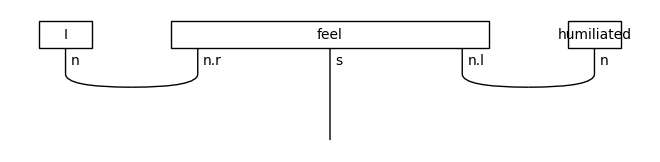

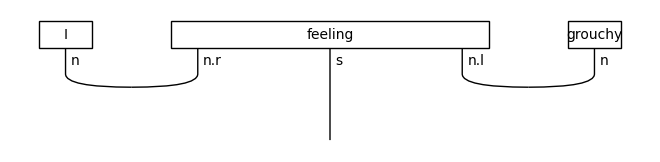

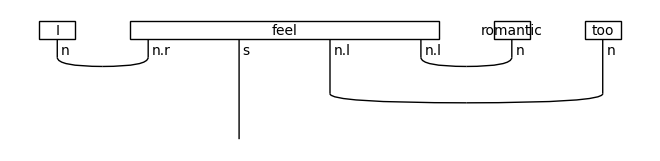

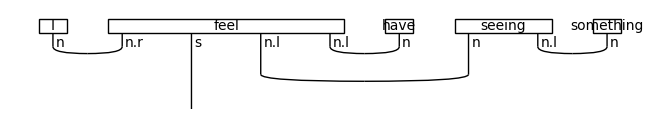

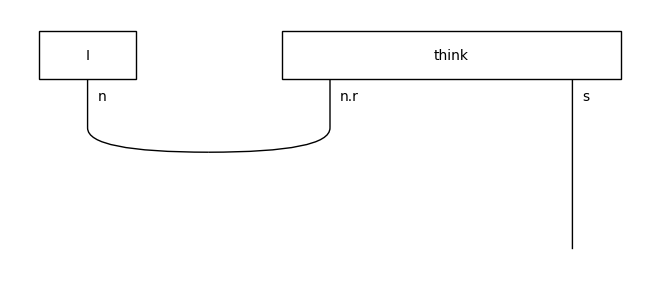

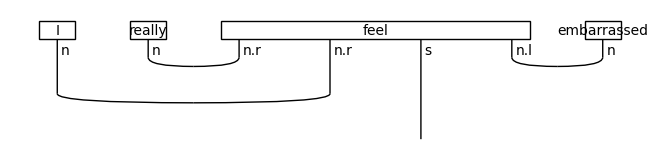

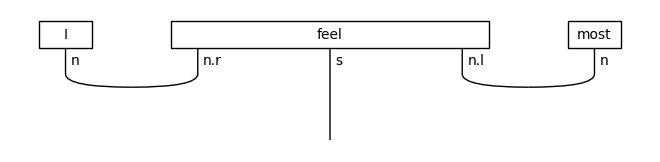

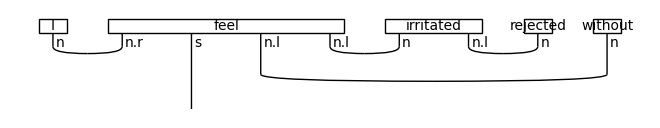

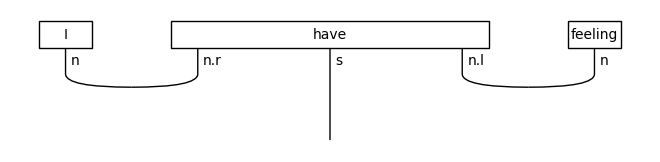

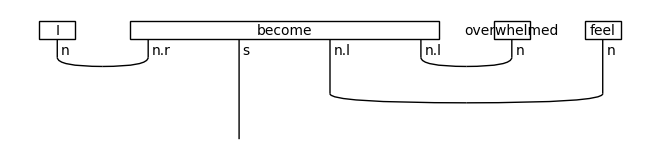

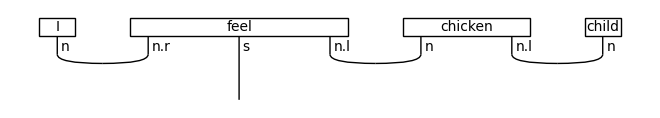

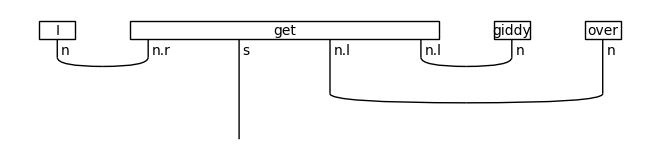

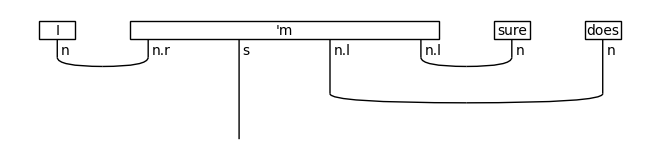

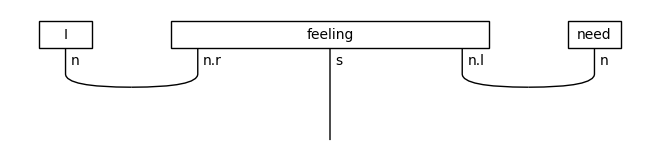

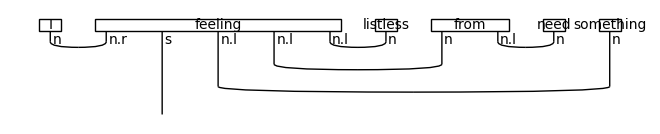

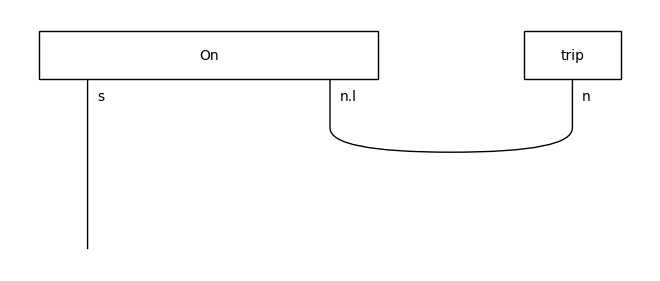

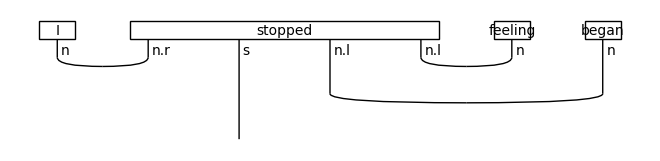

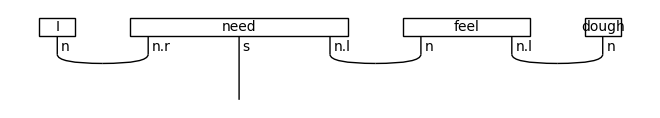

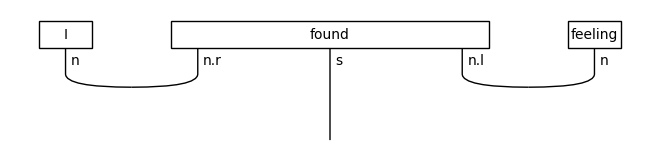

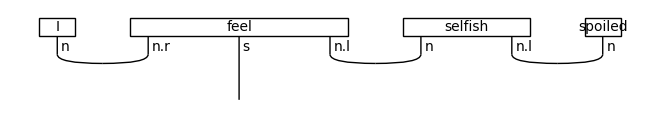

In [12]:
for d in range(0,20):
    draw(train_diagrams[d])

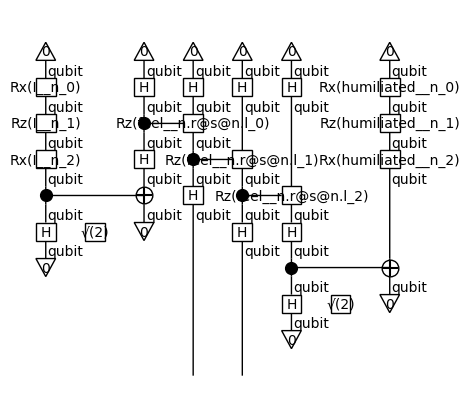

In [11]:
# 量子回路設計
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 2}, n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

# チェック用
train_circuits[0].draw(figsize=(4, 4))

In [18]:
# モデル
from lambeq import NumpyModel
all_circuits = train_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

# 損失関数
from lambeq.training import CELoss4, CELoss8
ce = CELoss4(use_jax=True)

# 目的関数
def acc(y_hat, y):
        ptrue= []
        for s  in range(len(y)):
            s0=y[s,0,0]
            s1=y[s,0,1]
            s2=y[s,1,0]
            s3=y[s,1,1]
            ptrue.append(np.array([s0, s1, s2, s3]))
            
        qtrue=np.array(ptrue)
 
        ppredic= [ ]
        for s in range(len(y_hat)):
            p0=y_hat[s,0,0]
            p1=y_hat[s,0,1]
            p2=y_hat[s,1,0]
            p3=y_hat[s,1,1]
            q0=abs(p0)**2
            q1=abs(p1)**2
            q2=abs(p2)**2
            q3=abs(p3)**2
            qq=q0+q1+q2+q3
            q0n=q0/qq
            q1n=q1/qq
            q2n=q2/qq
            q3n=q3/qq
            ppredic.append(np.array([q0n,q1n,q2n,q3n]))
        
        ppre=np.array(ppredic)
    
        Error=0.0
        
        for s  in range(len(y)):
            p=(ppre[s,0]-qtrue[s,0])**2+(ppre[s,1]-qtrue[s,1])**2+(ppre[s,2]-qtrue[s,2])**2+(ppre[s,3]-qtrue[s,3])**2
            #p=numpy.dot(ppre[s,:], ptrue[s,:])
            Error= Error+p
            Error=Error/len(y)
            AC=1.0-Error

        return AC

In [12]:
# モデル
from lambeq import NumpyModel
all_circuits = train_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

# 損失関数
from lambeq.training import CELoss4
ce = CELoss4(use_jax=True)

def acc(y_hat, y):
    """
    y_hat: 予測出力（batch_size, 2, 2）
    y: 正解ラベル（batch_size, 2, 2）
    """
    # 複素数の絶対値を取る
    y_hat_real = np.abs(y_hat) ** 2 if np.iscomplexobj(y_hat) else y_hat

    # 各サンプルをflattenして比較
    y_hat_flat = y_hat_real.reshape(len(y_hat), -1)
    y_flat = y.reshape(len(y), -1)

    # argmaxを取ってクラス化（4通りのラベル → 0,1,2,3）
    pred_labels = np.argmax(y_hat_flat, axis=1)
    true_labels = np.argmax(y_flat, axis=1)

    # 正解率を計算
    correct = np.sum(pred_labels == true_labels)
    accuracy = correct / len(y)

    return accuracy

In [13]:
# 学習の設定
BATCH_SIZE = 4
LEARNING_RATE = 3e-2
EPOCHS = 100
SEED = 0

trainer = QuantumTrainer(
    model,
    loss_function=ce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=0
)

from lambeq import Dataset

train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(test_circuits, test_labels, shuffle=False)

Epoch 20:   train/loss: 1.2897   valid/loss: 1.9459   train/time: 48m19s   valid/time: 8m4s   train/acc: 0.3467   valid/acc: 0.3542
Epoch 40:   train/loss: 0.7009   valid/loss: 1.6679   train/time: 1m55s   valid/time: 9.40s   train/acc: 0.4426   valid/acc: 0.3448
Epoch 60:   train/loss: 0.7086   valid/loss: 1.6489   train/time: 1m55s   valid/time: 9.25s   train/acc: 0.4859   valid/acc: 0.3511
Epoch 80:   train/loss: 0.7071   valid/loss: 1.6256   train/time: 1m56s   valid/time: 9.27s   train/acc: 0.5124   valid/acc: 0.3448
Epoch 100:  train/loss: 1.9178   valid/loss: 1.5930   train/time: 1m55s   valid/time: 9.26s   train/acc: 0.5377   valid/acc: 0.3981

Training completed!
train/time: 56m0s   train/time_per_epoch: 33.60s   train/time_per_step: 0.06s   valid/time: 8m41s   valid/time_per_eval: 5.21s


Test accuracy: 0.39811912


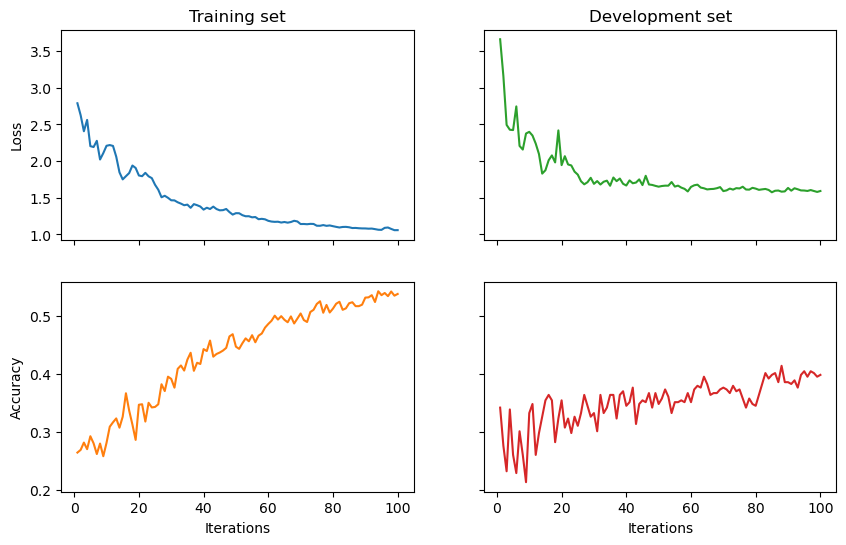

In [14]:
#学習と結果
trainer.fit(train_dataset, val_dataset, log_interval=20)

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), np.array(test_labels))
print('Test accuracy:', test_acc)

In [19]:
# text列が重複していないか確認
set_train = set(train_df["corrected_sentence"])
set_valid = set(test_df["corrected_sentence"])
print("重複数:", len(set_train & set_valid))

重複数: 1


In [20]:
# text列が存在するかチェック
assert "text" in train_df.columns and "text" in test_df.columns, "text列が存在しません"

# 重複している文を抽出
overlap_texts = set(train_df["corrected_sentence"]) & set(test_df["corrected_sentence"])

print(f"🔍 重複している文の数: {len(overlap_texts)}")

# 実際の重複文を確認（多い場合は一部だけ表示）
for i, t in enumerate(list(overlap_texts)[:10]):
    print(f"{i+1}. {t}")


🔍 重複している文の数: 1
1. I feel cared for and accepted.


In [ ]:
dup_in_train = train_df['corrected_sentence'].duplicated().sum()
print("train内の重複文数:", dup_in_train)
print(train_df['corrected_sentence'].duplicated())


train内の重複文数: 6
0        False
4        False
9        False
16       False
17       False
         ...  
15976    False
15984    False
15985     True
15988    False
15997    False
Name: corrected_sentence, Length: 2377, dtype: bool


: 

In [1]:
print("train_diagrams:", len(train_diagrams))
print("train_labels:", len(train_labels))
print("test_diagrams:", len(test_diagrams))
print("test_labels:", len(test_labels))

NameError: name 'train_diagrams' is not defined